# Выпускной проект "Стальная Птица"

## Описание проекта <a id="0"></a>

**Заказчик**: металлургический комбинат "Стальная Птица"

**Бизнес проблема**: необходимо уменьшить потребление электроэнергии на этапе обработки стали посредством контроля температуры сплава

**Цель проекта**: построить модель машинного обучения, которая будет предсказывать температуру сплава

**План работ**:  

1. [Описание проекта](#0)
2. [Описание, загрузка и осмотр данных](#1)
3. [Предобработка данных](#2)
4. [Объединение таблиц и создание новых признаков](#3)
5. [Анализ объединённого датафрейма](#4)
6. [Подготовка данных к обучению](#5)
7. [Разработка и тестирование моделей](#6)
8. [Анализ результатов молирования и выбор лучшей модели](#7)
9. [Заключение](#8)

## Описание, загрузка и осмотр данных <a id="1"></a>

In [1]:
#загрузка библиотек
!pip -q install shap
!pip -q install phik
!pip -q install catboost

#импорт библиотек
import seaborn as sns
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import spearmanr

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

import shap
import phik
from phik.report import plot_correlation_matrix

### Описание признаков

Данные комбината включают 7 датасетов:
1) `data_arc_new.csv` — данные об электродах:
    - **key** — номер партии (цикла, ковша);
    - **Начало нагрева дугой** — время начала нагрева;
    - **Конец нагрева дугой** — время окончания нагрева;
    - **Активная мощность** — значение активной мощности;
    - **Реактивная мощность** — значение реактивной мощности.
2) `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):
    - **key** — номер партии;
    - **Bulk 1 … Bulk 15** — объём подаваемого материала.
4) `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):
    - **key** — номер партии;
    - **Bulk 1 … Bulk 15** — время подачи материала.
6) `data_gas_new.csv` — данные о продувке сплава газом:
    - **key** — номер партии;
    - **Газ 1** — объём подаваемого газа.
8) `data_temp_new.csv` — результаты измерения температуры:
    - **key** — номер партии;
    - **Время замера** — время замера;
    - **Температура** — значение температуры.
10) `data_wire_new.csv` — данные о проволочных материалах (объём):
    - **key** — номер партии;
    - **Wire 1 … Wire 15** — объём подаваемых проволочных материалов.
12) `data_wire_time_new.csv` — данные о проволочных материалах (время):
    - **key** — номер партии;
    - **Wire 1 … Wire 15** — время подачи проволочных материалов.

### Загрузка данных

In [2]:
#напишем функцию для загрузки
def csv_reader(pth, parse_dates=None):
    if os.path.exists(pth):
        return pd.read_csv(pth, sep=',', decimal='.', parse_dates=parse_dates)
    elif os.path.exists(os.path.join('/datasets', pth)):
        return pd.read_csv(os.path.join('/datasets', pth), sep=',', decimal='.', parse_dates=parse_dates)
    else:
        return 'Something is wrong'

#загрузим таблицы и присвоим им переменные
data_arc_new = csv_reader('data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk_new = csv_reader('data_bulk_new.csv')
data_bulk_time_new = csv_reader('data_bulk_time_new.csv', parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])
data_gas_new = csv_reader('data_gas_new.csv')
data_temp_new = csv_reader('data_temp_new.csv', parse_dates=['Время замера'])
data_wire_new = csv_reader('data_wire_new.csv')
data_wire_time_new = csv_reader('data_wire_time_new.csv', parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])

### Осмотр данных

#### Даннык об электродах

Выведем первые 5 строчек таблицы:

In [3]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Выведем общую информацию о таблице:

In [4]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Выведем описательные статистики таблицы:

In [5]:
data_arc_new.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Проверим наличие явных дубликатов:

In [6]:
data_arc_new.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'key'], axis=1).duplicated().sum()

0

Проверим наличие пропусков:

In [7]:
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Посмотрим на распределение признаков:

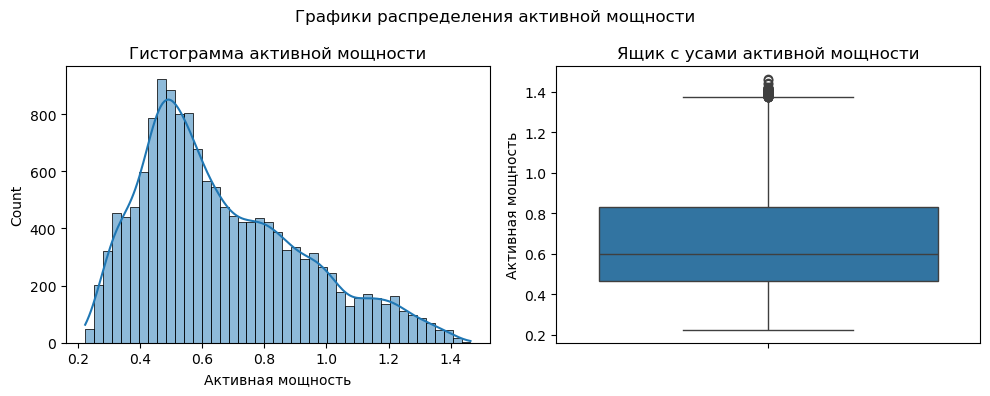

In [8]:
#Активная мощность
plt.rcParams['figure.figsize'] = 10, 4

fig, axes = plt.subplots(1, 2)

sns.histplot(data_arc_new['Активная мощность'], kde=True, ax=axes[0])
axes[0].set_title('Гистограмма активной мощности')

sns.boxplot(data_arc_new['Активная мощность'], ax=axes[1])
axes[1].set_title('Ящик с усами активной мощности')

plt.suptitle('Графики распределения активной мощности')

plt.tight_layout()
plt.show()

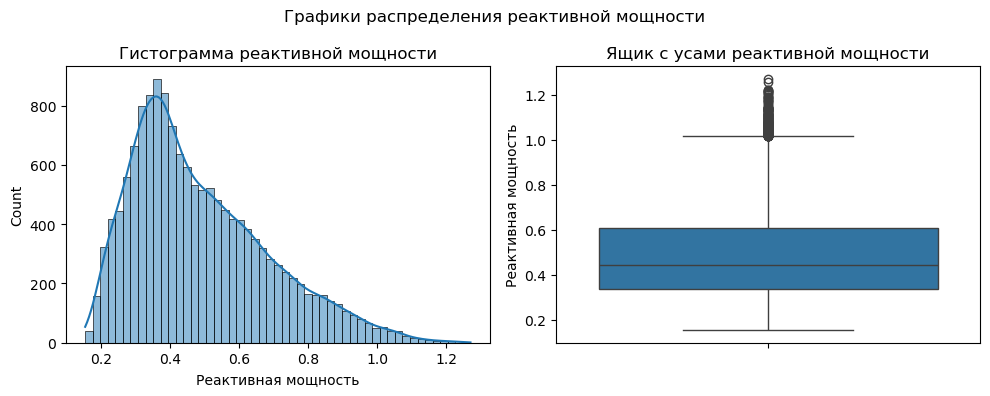

In [9]:
#Реактивная мощность
plt.rcParams['figure.figsize'] = 10, 4

fig, axes = plt.subplots(1, 2)

sns.histplot(data_arc_new[data_arc_new['Реактивная мощность'] != -715.479924]['Реактивная мощность'], kde=True, ax=axes[0])
axes[0].set_title('Гистограмма реактивной мощности')

sns.boxplot(data_arc_new[data_arc_new['Реактивная мощность'] != -715.479924]['Реактивная мощность'], ax=axes[1])
axes[1].set_title('Ящик с усами реактивной мощности')

plt.suptitle('Графики распределения реактивной мощности')

plt.tight_layout()
plt.show()

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `14876` записей
2) `Пропусков` и явных `дубликатов` нет
3) Присутствует одна запись c `аномально` низкой реактивной мощностью (`-715` при медиане `0.44`) - информация о ковше с данной аномалией впоследствии будет `убрана`
4) Время начала и конца нагрева дугой находится в промежутке с `3 мая 2019` по `6 сентября 2019`
5) Распределение активной и реактивной мощность `левостороннее нормальное` со средним равным `0.66` и `0.44` соответственно, присутствуют `статистические выбросы`, однако они будут `оставлены` в изначальном виде в целях сохранения информации о специфики обработки сплава

#### Данные о подаче сыпучих материалов (объём)

Выведем случайные 5 строчек таблицы:

In [10]:
data_bulk_new.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
998,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.0,NaN
1696,1756,NaN,NaN,252.0,NaN,70.0,81.0,NaN,NaN,NaN,NaN,NaN,205.0,NaN,99.0,204.0
2760,2864,NaN,NaN,NaN,NaN,NaN,116.0,NaN,NaN,NaN,NaN,NaN,522.0,NaN,234.0,106.0
430,456,NaN,NaN,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314.0,NaN,202.0,175.0
145,159,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,NaN


Выведем общую информацию о таблице:

In [11]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Выведем описательные статистики таблицы:

In [12]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Проверим наличие явных дубликатов:

In [13]:
data_bulk_new.drop(['key'], axis=1).duplicated().sum()

80

Проверим наличие пропусков:

In [14]:
data_bulk_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Посмотрим на распределение признаков:

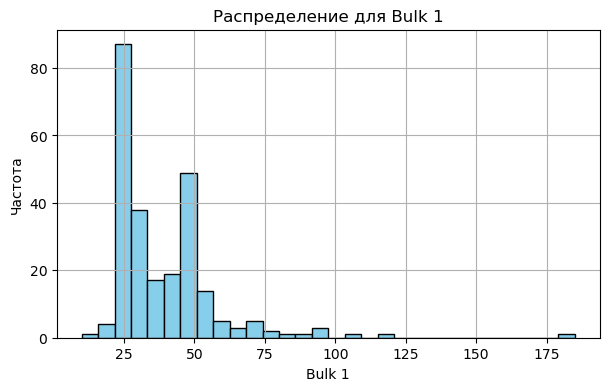

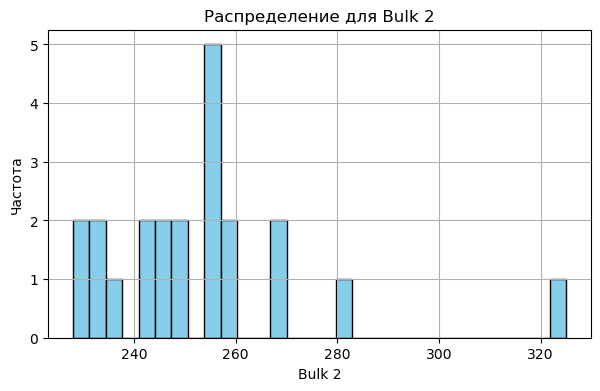

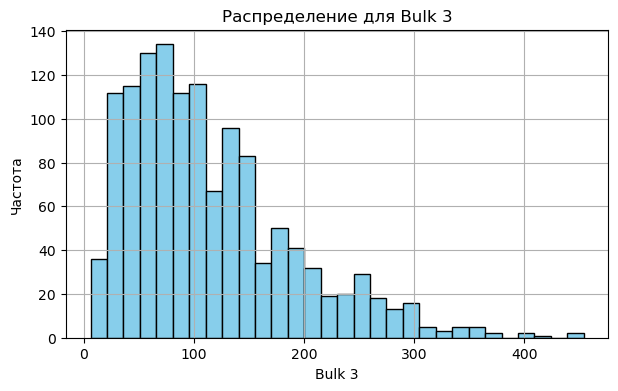

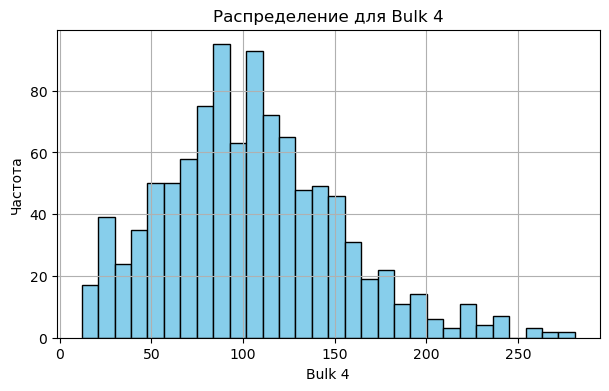

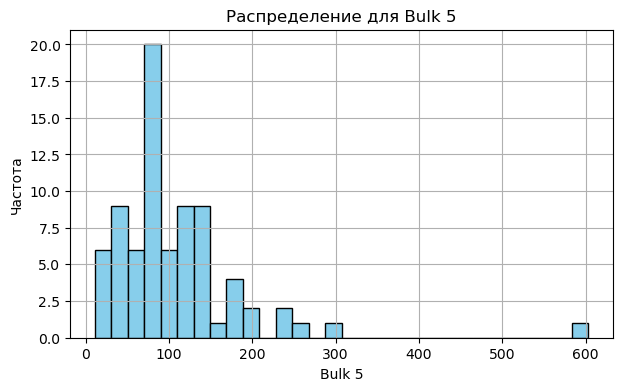

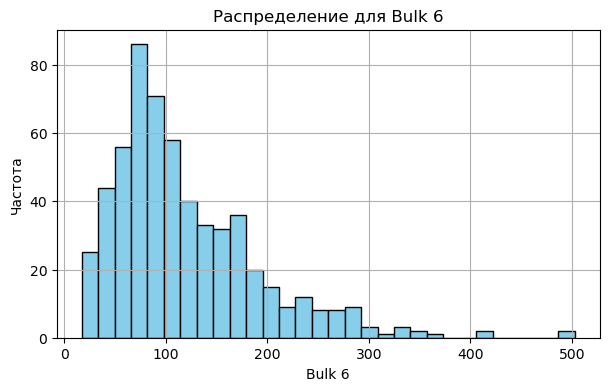

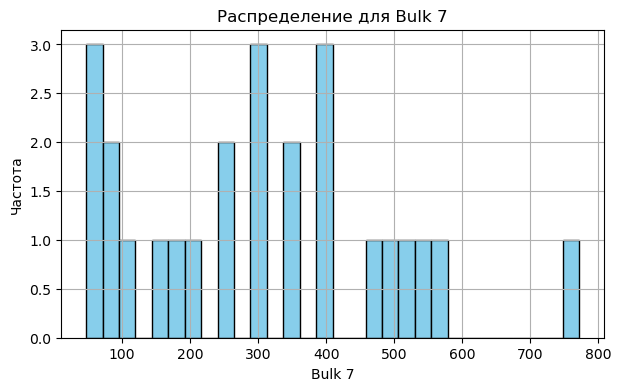

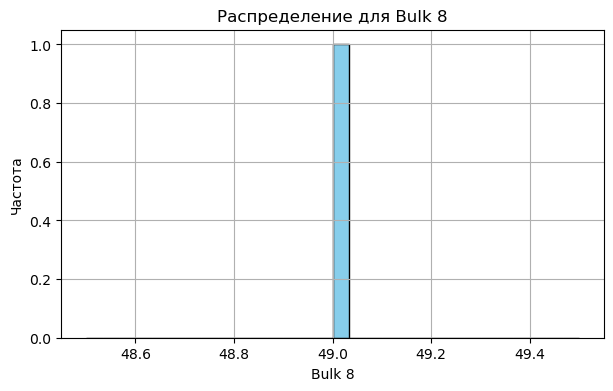

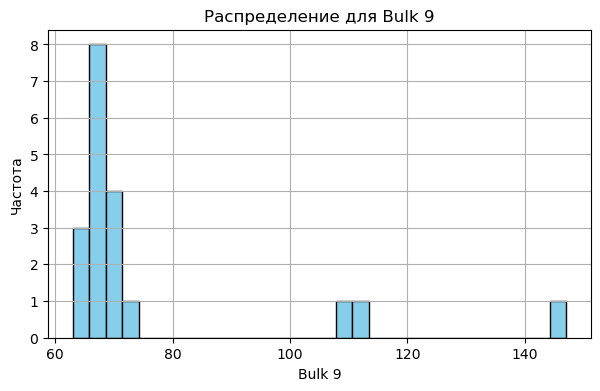

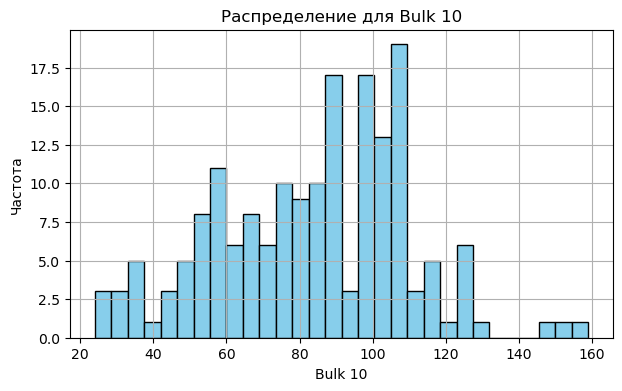

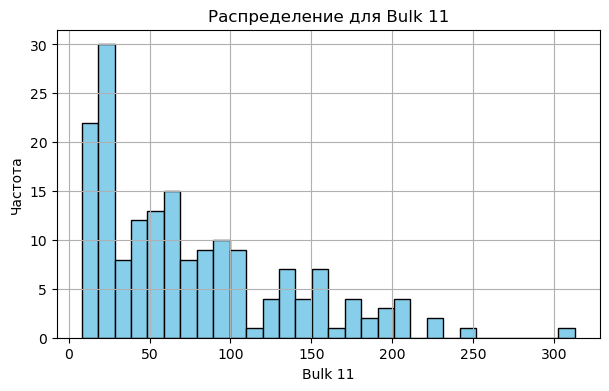

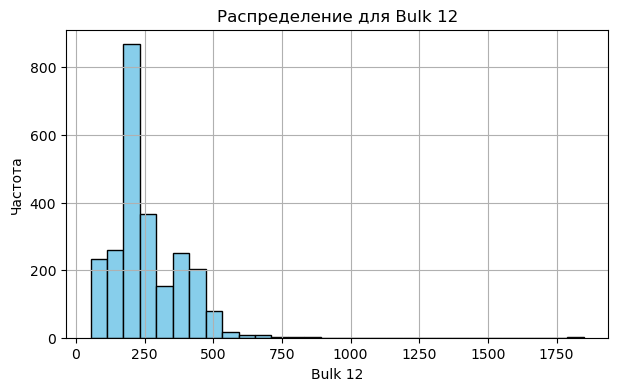

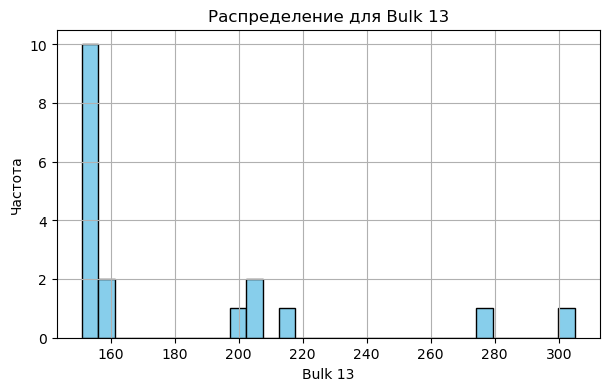

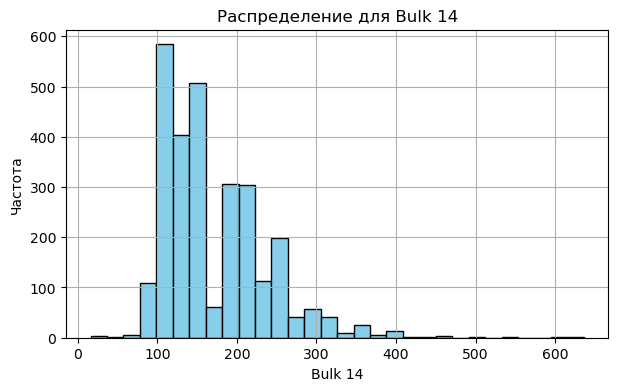

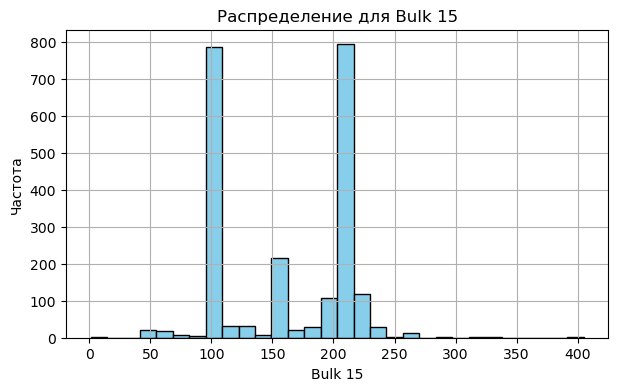

In [15]:
for column in data_bulk_new.columns[1:]:
    plt.figure(figsize=(7, 4))
    plt.hist(data_bulk_new[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `3129` записей - для каждого ковша по одной записи.
2) Есть множество `пропусков`, означающих отсутствие добавление той или иной примеси - впоследствии они будут заменены на 0
3) Выявлено 80 `дубликатов` - требуется проверка информации по дублирующимся в данной таблице ковшам в других таблицах
4) `Аномальных` значений по сыпучим материалам не наблюдается;
5) Можно выделить `три группы` сыпучих материалов:
    - Сыпучие материли `высокой` популярности: Bulk 3, Bulk 4, Bulk 12, Bulk 14 и Bulk 15 (`>1000`)
    - Сыпучие материли `средней` популярности: Bulk 1, Bulk 6, Bulk 10, Bulk 11 и Bulk 15 (`>=100`)
    - Сыпучие материли `низкой` популярности: Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9 и Bulk 13 (`<100`)
6) Объёмы сыпучих материалов высокой и средней популярности имеют `нормальное распределение`, за исключением `Bulk 15`, у которого два наиболее распространненных объема (~100 и 200)
7) Объём сыпучих материлов низкой популярности `не имеют` нормального распределения

#### Данные о подаче сыпучих материалов (время)

Выведем случайные 5 строчек таблицы:

In [16]:
data_bulk_time_new.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
148,162,NaT,NaT,2019-05-09 20:07:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-09 20:02:11,NaT,2019-05-09 19:55:41,2019-05-09 19:45:03
2834,2940,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-27 02:29:09,NaT,2019-08-27 02:29:09,2019-08-27 02:29:09
740,774,NaT,NaT,2019-06-02 18:20:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-06-02 18:12:19,NaT,2019-06-02 18:12:19,2019-06-02 18:12:19
1995,2066,NaT,NaT,NaT,2019-07-25 20:47:09,2019-07-25 20:44:18,NaT,NaT,NaT,NaT,NaT,NaT,2019-07-25 20:32:55,NaT,2019-07-25 20:26:55,2019-07-25 20:17:30
2573,2671,NaT,NaT,NaT,NaT,NaT,2019-08-17 01:14:04,NaT,NaT,NaT,NaT,2019-08-17 01:16:25,2019-08-17 01:14:04,NaT,NaT,2019-08-17 01:07:49


Выведем общую информацию о таблице:

In [17]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


Выведем описательные статистики таблицы:

In [18]:
data_bulk_time_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_bulk_time_new.drop(['key'], axis=1).duplicated().sum()

0

Проверим наличие пропусков:

In [20]:
data_bulk_time_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `3129` записей - для каждого ковша по одной записи (следовательно, есть согласованность с предыдущей таблицей)
2) Пропуски в таблице аналогичны таблице с объемом (следовательно, данные согласованы)

#### Данные о продувке сплава газом

Выведем случайные 5 строчек таблицы:

In [21]:
data_gas_new.sample(5)

,key,Газ 1
705,708,15.824232
551,554,8.385707
872,875,23.206485
1231,1234,11.485524
69,70,6.688318


Выведем общую информацию о таблице:

In [22]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Выведем описательные статистики таблицы:

In [23]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Проверим наличие явных дубликатов:

In [24]:
data_gas_new.drop(['key'], axis=1).duplicated().sum()

0

Проверим наличие пропусков:

In [25]:
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

Проверим, нет ли повторяющихся значений в столбце `key`:

In [26]:
len(set(data_gas_new['key']))

3239

Посмотрим на распределение признаков:

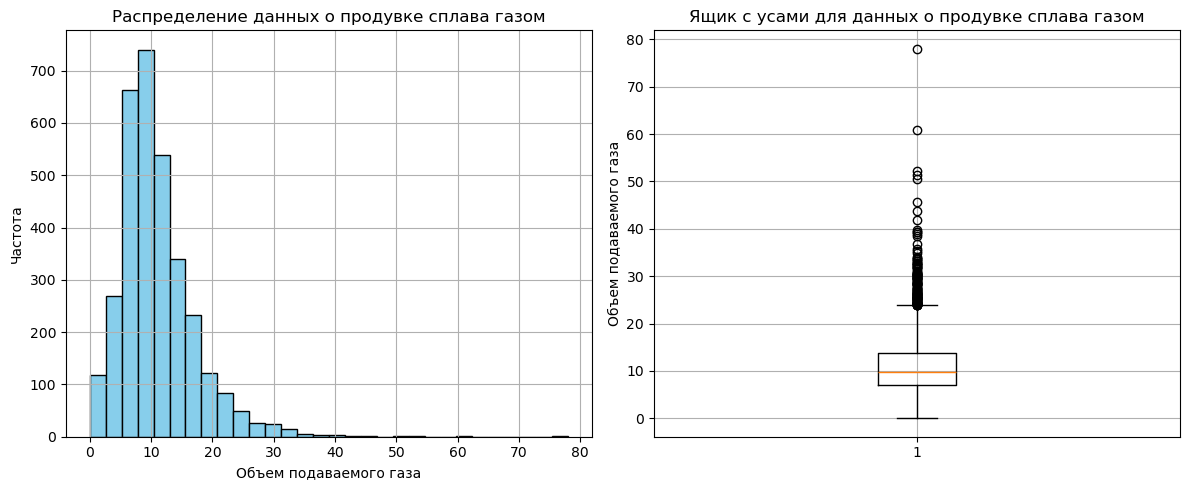

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(data_gas_new['Газ 1'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение данных о продувке сплава газом')
axes[0].set_xlabel('Объем подаваемого газа')
axes[0].set_ylabel('Частота')
axes[0].grid(True)

axes[1].boxplot(data_gas_new['Газ 1'])
axes[1].set_title('Ящик с усами для данных о продувке сплава газом')
axes[1].set_ylabel('Объем подаваемого газа')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `3239` записей - для каждого ковша по одной записи (следовательно в этой таблице информация о большем количестве ковшей, чем в ранее рассмотренных)
2) `Пропуски` и `дубликаты` отсутствуют
4) `Аномальных` значений по продувке газа нет, однако `есть выбросы` (не подлежат удалению)
5) Объем подаваемого газа имеет `нормальное распределение`

#### Результаты измерения температуры

Выведем случайные 5 строчек таблицы:

In [28]:
data_temp_new.sample(5)

,key,Время замера,Температура
17193,3074,2019-09-01 00:31:53,NaN
8979,1605,2019-07-02 16:10:24,1581.0
9588,1710,2019-07-06 04:16:39,1590.0
16663,2974,2019-08-28 12:34:20,NaN
14395,2573,2019-08-13 14:58:12,NaN


Выведем общую информацию о таблице:

In [29]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Выведем описательные статистики таблицы:

In [30]:
data_temp_new.describe()

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


Проверим наличие явных дубликатов:

In [31]:
data_temp_new.drop(['key', 'Время замера'], axis=1).duplicated().sum()

17919

Проверим наличие пропусков:

In [32]:
data_temp_new.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

Посмотрим на распределение признаков:

Проверим количество уникальных значений в столбце "key":

In [33]:
len(set(data_temp_new['key']))

3216

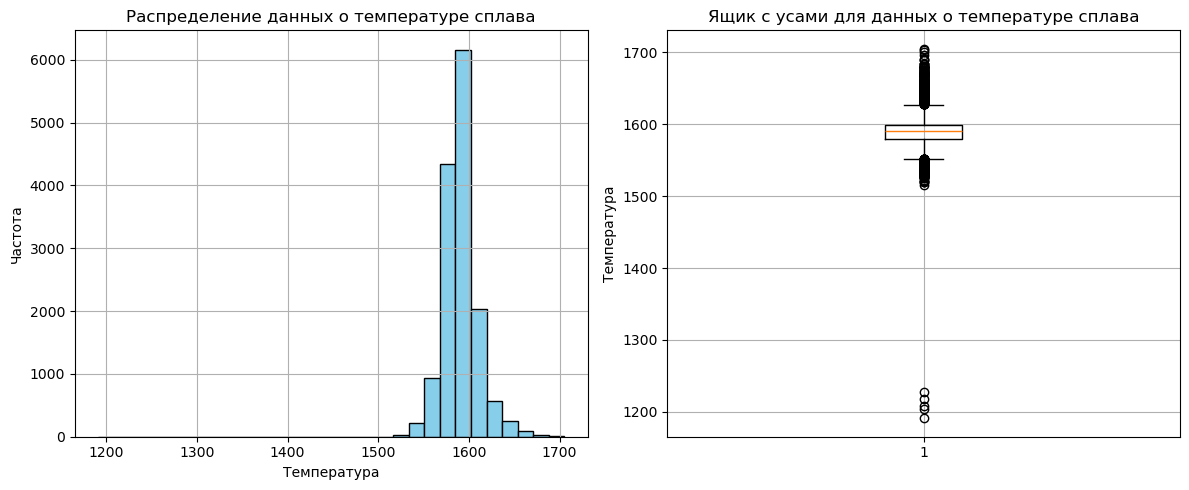

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(data_temp_new['Температура'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение данных о температуре сплава')
axes[0].set_xlabel('Температура')
axes[0].set_ylabel('Частота')
axes[0].grid(True)

axes[1].boxplot(data_temp_new['Температура'].dropna())
axes[1].set_title('Ящик с усами для данных о температуре сплава')
axes[1].set_ylabel('Температура')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `18092` записей, из них `3216` уникальных циклов (кошвей)
2) Присутствуют `пропуски` в столбце с температурой, если таковые будут на последнем этапе цикла (целевой признак) - инфорамция о таких ковшах будет удалена
3) Присутствуют `аномальные записи` с температурой меньше температуры плавления стали (`<1400`), информация о таких ковшах будет удалена
4) В таблицы есть `выбросы` (не подлежат удалению)
5) Данные по температуре имеют `нормальное распределение` со средним `1591`

#### Данные о проволочных материалах (объём)

Выведем случайные 5 строчек таблицы:

In [35]:
data_wire_new.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1312,1383,197.823594,15.110160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,788,145.267196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1482,1558,178.120804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
822,876,170.398804,29.164719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,602,67.111198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выведем общую информацию о таблице:

In [36]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Проверим количество уникальных значений в столбце "key":

In [37]:
len(set(data_wire_new['key']))

3081

Выведем описательные статистики таблицы:

In [38]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Проверим наличие явных дубликатов:

In [39]:
data_wire_new.drop(['key'], axis=1).duplicated().sum()

403

Проверим наличие пропусков:

In [40]:
data_wire_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Посмотрим на распределение признаков:

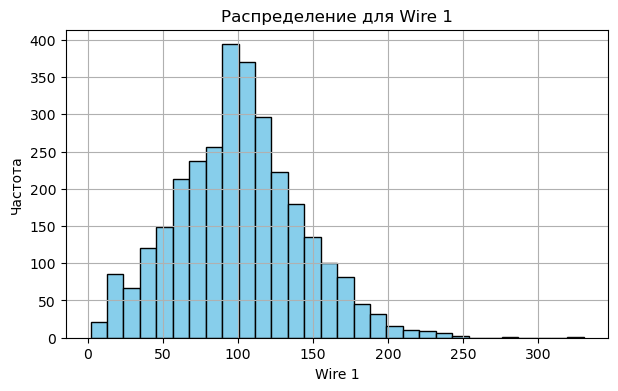

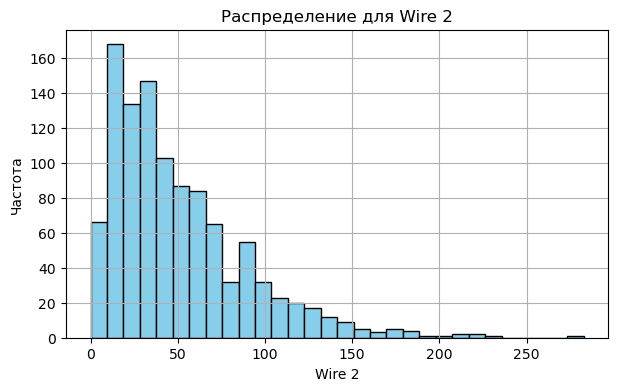

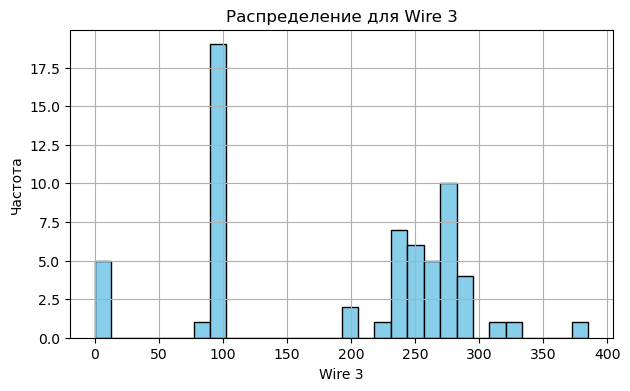

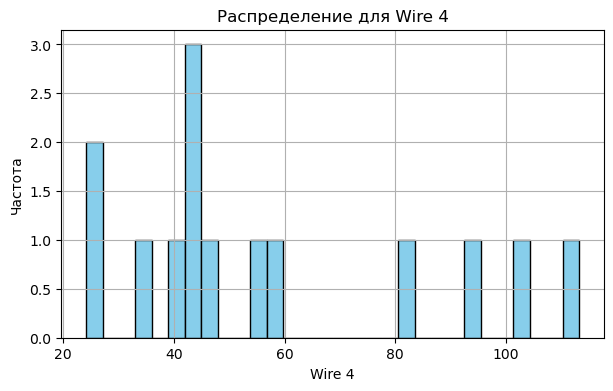

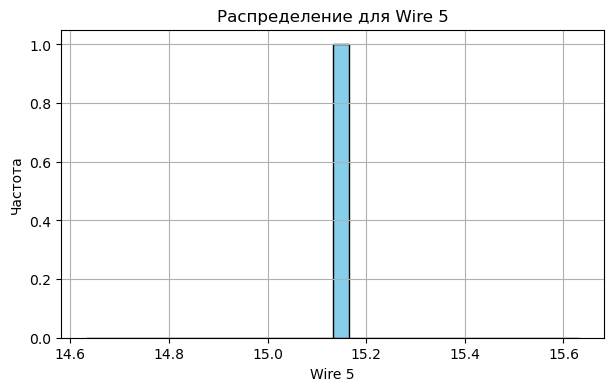

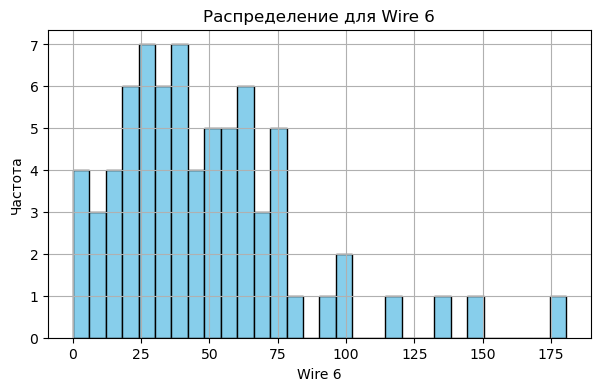

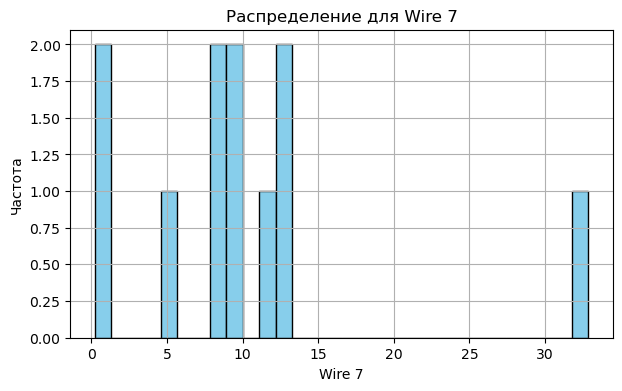

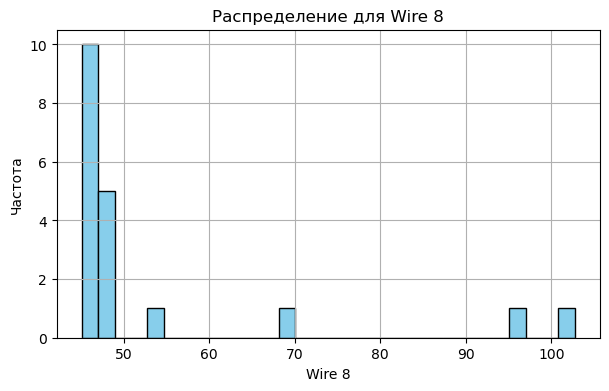

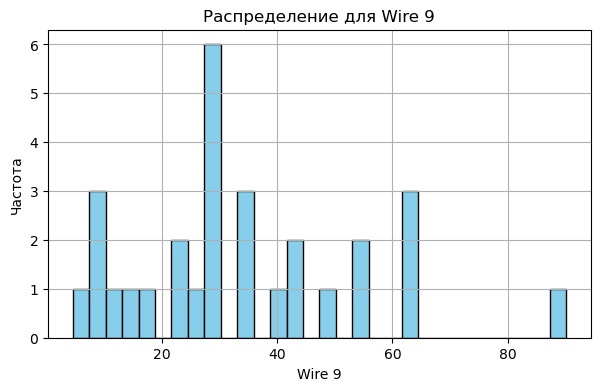

In [41]:
for column in data_wire_new.columns[1:]:
    plt.figure(figsize=(7, 4))
    plt.hist(data_wire_new[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `3081` запись - для каждого ковша по одной записи.
2) Есть множество `пропусков`, означающих отсутствие добавление того или иного проволочного материала - впоследствии они будут заменены на 0
3) Выявлено 403 `дубликата` - требуется проверка информации по дублирующимся в данной таблице ковшам в других таблицах
4) `Аномальных` значений по добавлнию проволочных материалов не наблюдается;
5) Можно выделить `две группы` сыпучих материалов:
    - Сыпучие материли `высокой` популярности: Wire 1 и Wire 2 (`>=1000`)
    - Сыпучие материли `низкой` популярности: Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9 (`<1000`). Wire 5 добавлялся лишь один раз.
6) Данные по объёму подаваемых проволочных материалов `высокой` популярности имеют `нормальное распределение`
7) Данные по объёму подаваемых проволочных материалов `низкой` популярности `не имеют` нормального распределения

#### Данные о проволочных материалах (время)

Выведем случайные 5 строчек таблицы:

In [42]:
data_wire_time_new.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
376,408,2019-05-19 03:40:33,2019-05-19 03:36:53,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2028,2126,2019-07-28 09:44:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2386,2513,2019-08-11 00:26:34,2019-08-11 00:16:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3054,3215,2019-09-05 19:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
788,842,2019-06-05 06:46:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Выведем общую информацию о таблице:

In [43]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Выведем описательные статистики таблицы:

In [44]:
data_wire_time_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data_wire_time_new.drop(['key'], axis=1).duplicated().sum()

0

Проверим наличие пропусков:

In [46]:
data_wire_time_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Вывод по итогам исследования таблицы**:
1) Таблица содержит `3181` запись - для каждого ковша по одной записи (следовательно, есть согласованность с предыдущей таблицей)
2) Пропуски в таблице аналогичны таблице с объемом подаеваемоых проволочных материалов (следовательно, данные согласованы)

## Предобработка данных <a id="2"></a>

### Аномалия в реактивной мощности

Посмотрим какой ковш имеет аномальное значение:

In [47]:
data_arc_new[data_arc_new['Реактивная мощность'] < 0] #ковш 2116

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Удалим из всех таблиц информацию по данному ковшу:

In [48]:
data_arc_new = data_arc_new[data_arc_new['key']!=2116]
data_bulk_new = data_bulk_new[data_bulk_new['key']!=2116]
data_bulk_time_new = data_bulk_time_new[data_bulk_time_new['key']!=2116]
data_gas_new = data_gas_new[data_gas_new['key']!=2116]
data_temp_new = data_temp_new[data_temp_new['key']!=2116]
data_wire_new = data_wire_new[data_wire_new['key']!=2116]
data_wire_time_new = data_wire_time_new[data_wire_time_new['key']!=2116]

### Замена пропусков на 0 в материалах

Заменив в таблицах по подаче в сплав примесей пропущенные значения на 0:

In [49]:
data_bulk_new = data_bulk_new.fillna(0)
data_bulk_time_new = data_bulk_time_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)
data_wire_time_new = data_wire_time_new.fillna(0)

### Аномалия в температуре сплава

Посмотрим какие ковши имеет аномальные значения температуры сплава:

In [50]:
data_temp_new[data_temp_new['Температура']<1450] # ковши №№ 867, 1214, 1619, 2052, 2561

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Удалим из всех таблиц информацию по данным ковшам:

In [51]:
data_arc_new = data_arc_new[~data_arc_new['key'].isin([867, 1214, 1619, 2052, 2561])]
data_bulk_new = data_bulk_new[~data_bulk_new['key'].isin([867, 1214, 1619, 2052, 2561])]
data_bulk_time_new = data_bulk_time_new[~data_bulk_time_new['key'].isin([867, 1214, 1619, 2052, 2561])]
data_gas_new = data_gas_new[~data_gas_new['key'].isin([867, 1214, 1619, 2052, 2561])]
data_temp_new = data_temp_new[~data_temp_new['key'].isin([867, 1214, 1619, 2052, 2561])]
data_wire_new = data_wire_new[~data_wire_new['key'].isin([867, 1214, 1619, 2052, 2561])]
data_wire_time_new = data_wire_time_new[~data_wire_time_new['key'].isin([867, 1214, 1619, 2052, 2561])]

### Пропуски в температуре сплава

Создадим переменную, где будет информация о ковшах, по которым есть пропуски в температуре:

In [52]:
nan_temp = list(set(data_temp_new[data_temp_new['Температура'].isna()]['key']))

Удалим из всех таблиц информацию по данным ковшам:

In [53]:
data_arc_new = data_arc_new[~data_arc_new['key'].isin(nan_temp)]
data_bulk_new = data_bulk_new[~data_bulk_new['key'].isin(nan_temp)]
data_bulk_time_new = data_bulk_time_new[~data_bulk_time_new['key'].isin(nan_temp)]
data_gas_new = data_gas_new[~data_gas_new['key'].isin(nan_temp)]
data_temp_new = data_temp_new[~data_temp_new['key'].isin(nan_temp)]
data_wire_new = data_wire_new[~data_wire_new['key'].isin(nan_temp)]
data_wire_time_new = data_wire_time_new[~data_wire_time_new['key'].isin(nan_temp)]

## Объединение таблиц и создание новых признаков <a id="3"></a>

Объект моделирования - ковш, целевая переменная - температура сплава на последнем этапе цикла.

### Температура

Сформируем начальную и итоговую температуру ковша:

In [54]:
t1 = data_temp_new[data_temp_new['Время замера'].isin(list(data_temp_new.groupby('key')['Время замера'].min()))].reset_index(drop=True).drop(['Время замера'], axis=1)
t2 = data_temp_new[data_temp_new['Время замера'].isin(list(data_temp_new.groupby('key')['Время замера'].max()))].reset_index(drop=True).drop(['Время замера'], axis=1)
t3 = (data_temp_new.groupby('key')['Время замера'].max() - data_temp_new.groupby('key')['Время замера'].min()).dt.total_seconds().reset_index()

t1.columns=['key', 'start_temp']
t2.columns=['key', 'end_temp']
t3.columns=['key', 'heating_time']

In [55]:
data_temp_new = pd.merge(t1, t2, on='key')
data_temp_new = pd.merge(data_temp_new, t3, on='key')
data_temp_new.head()

,key,start_temp,end_temp,heating_time
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


### Данные об электродах

Создадим новые факторы на основе активой и реактивной мощности, а также времени нагрева:

In [56]:
#Агрегированная мощность
data_arc_new['power_aggregated'] = np.sqrt((data_arc_new['Активная мощность'])**2 + (data_arc_new['Реактивная мощность'])**2)

#Коэффициент мощности - признак может быть полезен, так как позволяет учесть "эффективность" использования энергии
data_arc_new['power_factor'] = data_arc_new['Активная мощность'] / np.sqrt((data_arc_new['Активная мощность'])**2 + (data_arc_new['Реактивная мощность'])**2)

#Угол сдвига фаз - признак может быть полезен для анализа характера нагрузки и электрических сетей
data_arc_new['phase_shift_angle'] = np.arctan2(data_arc_new['Реактивная мощность'], data_arc_new['Активная мощность'])

# Статистики по мощности
data_arc_new['power_mean'] = data_arc_new[['Активная мощность', 'Реактивная мощность']].mean(axis=1)
data_arc_new['power_std'] = data_arc_new[['Активная мощность', 'Реактивная мощность']].std(axis=1)
data_arc_new['power_median'] = data_arc_new[['Активная мощность', 'Реактивная мощность']].median(axis=1)

data_arc_new['electrodes_time'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.total_seconds()

data_arc_new = data_arc_new.groupby('key')[['electrodes_time', 'Активная мощность', 'Реактивная мощность', 'power_aggregated',
       'power_factor', 'phase_shift_angle', 'power_mean', 'power_std',
       'power_median']].sum().reset_index()

data_arc_new.head()

,key,electrodes_time,Активная мощность,Реактивная мощность,power_aggregated,power_factor,phase_shift_angle,power_mean,power_std,power_median
0,1,1098.0,3.036730,2.142821,3.718736,4.083428,3.072348,2.589776,0.632089,2.589776
1,2,811.0,2.139408,1.453357,2.588349,3.301105,2.393023,1.796382,0.485111,1.796382
2,3,655.0,4.063641,2.937457,5.019223,4.048621,3.126052,3.500549,0.796332,3.500549
3,4,741.0,2.706489,2.056992,3.400038,3.175691,2.613420,2.381741,0.459264,2.381741
4,5,869.0,2.252950,1.687991,2.816980,3.187274,2.590224,1.970471,0.399486,1.970471


### Объединение

Объединим данные в один датасет:

In [57]:
dataset = data_temp_new.merge(data_arc_new, on='key', how='inner')
dataset = dataset.merge(data_bulk_new, on='key', how='inner')
dataset = dataset.merge(data_gas_new, on='key', how='inner')
dataset = dataset.merge(data_wire_new, on='key', how='inner')

Оформим стилистически верно датасет:

In [58]:
dataset.columns = ['key', 'start_temp', 'end_temp', 'heating_time', 'electrodes_time', 'active_power', 'reactive_power', 'power_aggregated', 'power_factor',
       'phase_shift_angle', 'power_mean', 'power_std', 'power_median',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

dataset.drop(columns=['key'], inplace=True)

temperature_column = dataset['end_temp']
dataset.pop('end_temp')
dataset['end_temp'] = temperature_column

dataset.head()

,start_temp,heating_time,electrodes_time,active_power,reactive_power,power_aggregated,power_factor,phase_shift_angle,power_mean,power_std,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,end_temp
0,1571.0,1714.0,1098.0,3.036730,2.142821,3.718736,4.083428,3.072348,2.589776,0.632089,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0
1,1581.0,1265.0,811.0,2.139408,1.453357,2.588349,3.301105,2.393023,1.796382,0.485111,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0
2,1596.0,1753.0,655.0,4.063641,2.937457,5.019223,4.048621,3.126052,3.500549,0.796332,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1599.0
3,1601.0,1220.0,741.0,2.706489,2.056992,3.400038,3.175691,2.613420,2.381741,0.459264,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1625.0
4,1576.0,1536.0,869.0,2.252950,1.687991,2.816980,3.187274,2.590224,1.970471,0.399486,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0


**Выводы по результатам объединения данных**:
- Данные были переформатированы под построение модели так, чтобы целевым признаком выступала температуру сплава на последней итерации обработки сплава
- Были также посчитаны факторы мощности на основании активной и реактивной мощностей

## Анализ объединённого датафрейма<a id="4"></a>

### Исследовательский анализ

In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temp         2324 non-null   float64
 1   heating_time       2324 non-null   float64
 2   electrodes_time    2324 non-null   float64
 3   active_power       2324 non-null   float64
 4   reactive_power     2324 non-null   float64
 5   power_aggregated   2324 non-null   float64
 6   power_factor       2324 non-null   float64
 7   phase_shift_angle  2324 non-null   float64
 8   power_mean         2324 non-null   float64
 9   power_std          2324 non-null   float64
 10  power_median       2324 non-null   float64
 11  bulk_1             2324 non-null   float64
 12  bulk_2             2324 non-null   float64
 13  bulk_3             2324 non-null   float64
 14  bulk_4             2324 non-null   float64
 15  bulk_5             2324 non-null   float64
 16  bulk_6             2324 

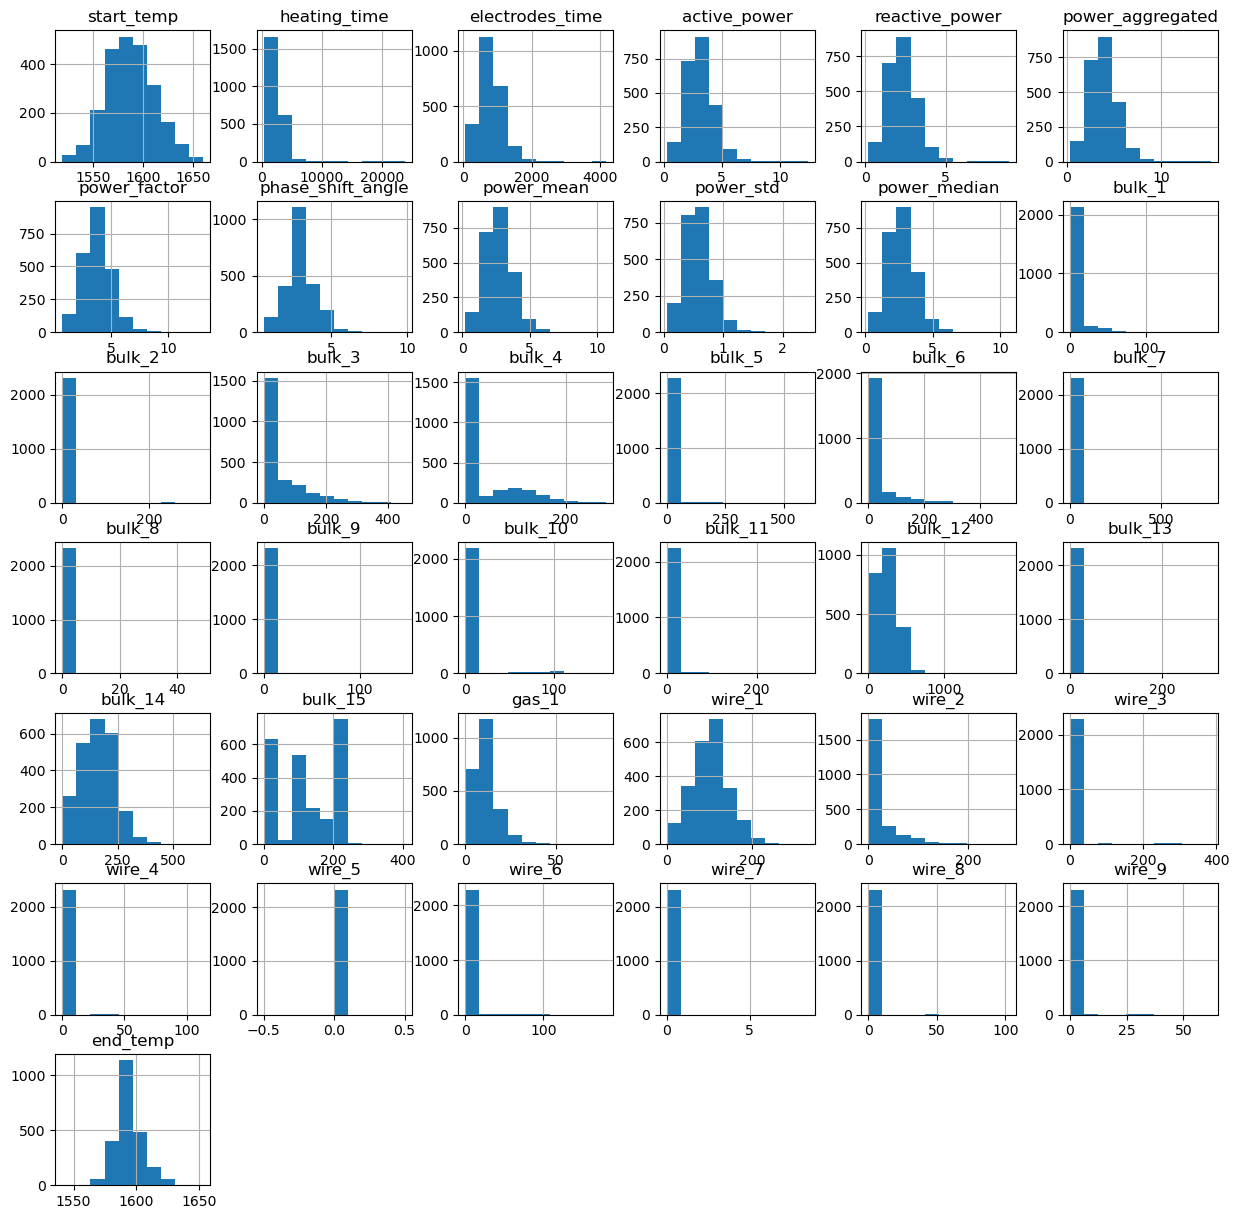

In [60]:
dataset.hist(figsize=(15,15))
plt.show()

**Выводы по исследовательскому анализу объединенного датасета**:
- Датасет `2324` записи по `36` признакам
- 14 признаков имеют `нормальное распределение`, в остальных признаках привалирует `нулевое значение`

### Корреляционный анализ

interval columns not set, guessing: ['start_temp', 'heating_time', 'electrodes_time', 'active_power', 'reactive_power', 'power_aggregated', 'power_factor', 'phase_shift_angle', 'power_mean', 'power_std', 'power_median', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'end_temp']


/opt/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable wire_5 for analysis 1. Dropping this column
  warnings.warn(


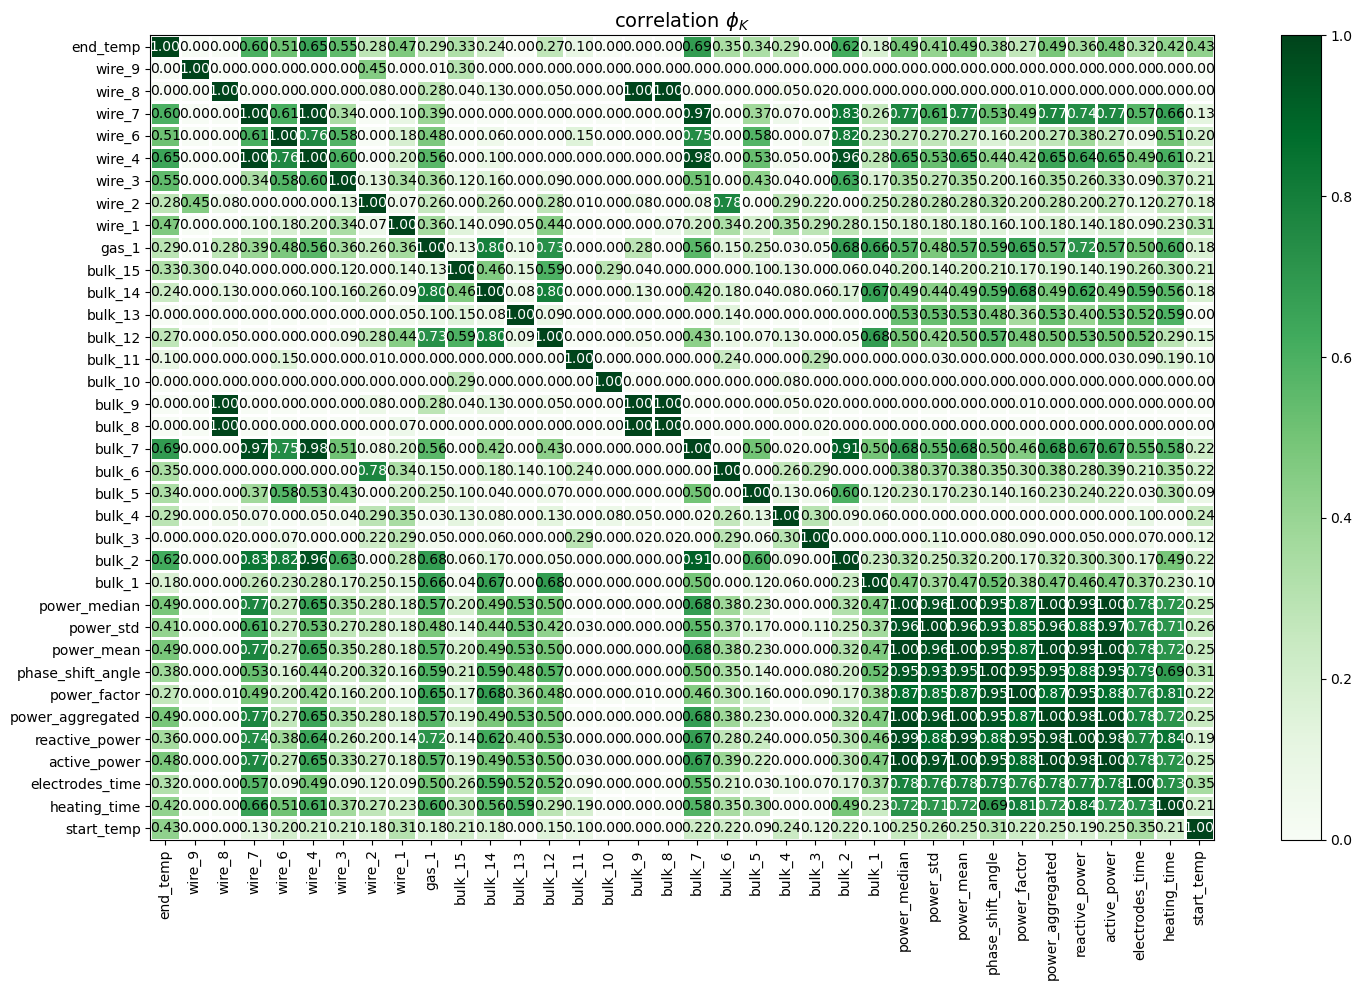

In [61]:
phik_overview = dataset.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1,
                        figsize=(15, 10))
plt.tight_layout()

**Вывод по разделу**:
 - Заметим, что имеет место мультиколлениарность
 - Ряд признаков почти почти ни с чем не коррелируют

## Подготовка данных к обучению <a id="5"></a>

Сформируем обучающую и тестовую выборки:

In [62]:
RANDOM_STATE = 60524

X = dataset.drop(columns=['end_temp'])
y = dataset['end_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

## Разработка и тестирование моделей <a id="6"></a>


### Linear Regression

Протестируем отдельн модель линейной регрессии, предварительно избавившься от мультиколленирности. Для этого удалим следуюшие признаки:
- 'wire_7', 'wire_6', 'wire_5', 'wire_4', 'wire_3', 'wire_2'
- 'bulk_6', 'bulk_6', 'bulk_5', 'bulk_2', 'bulk_1', 'bulk_9', 'bulk_8', 'bulk_7'
- 'reactive_power', 'active_power', 'power_factor', 'phase_shift_angle',
                          'power_mean', 'power_std', 'power_median'

In [63]:
RANDOM_STATE = 60524

X = dataset.drop(columns=['end_temp', 'wire_7', 'wire_6', 'wire_5', 'wire_4', 'wire_3', 'wire_2',
                         'bulk_6', 'bulk_6', 'bulk_5', 'bulk_2', 'bulk_1', 'bulk_9', 'bulk_8', 'bulk_7',
                          'reactive_power', 'active_power', 'power_factor', 'phase_shift_angle',
                          'power_mean', 'power_std', 'power_median'])
y = dataset['end_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [64]:
param_grid = {
#    'models__fit_intercept': [True, False],
#    'models__positive': [True, False]
}

pipe_final = Pipeline([
    ('preprocessor', StandardScaler()),
    ('models', LinearRegression())
])

In [65]:
grid_search = GridSearchCV(pipe_final, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

In [66]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('models', LinearRegression())]),
             n_jobs=-1, param_grid={}, scoring='neg_mean_absolute_error')

In [67]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002484,0.000093,0.000642,0.000033,{},-6.659559,-6.127742,-6.085971,-5.869695,-5.684326,-6.085459,0.328281,1


### RandomForestRegressor, CatBoostRegressor, SVR

In [68]:
param_distributions = [
    {
        'models': [RandomForestRegressor()],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [None, 10, 20]
    },
    {
        'models': [CatBoostRegressor(verbose=False)],
        'models__iterations': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1]
    },
     {
        'models': [SVR()],
        'models__C': [0.1, 1, 10],
        'models__gamma': ['scale', 'auto']
    }
]


pipe_final = Pipeline([
    ('preprocessor', StandardScaler()),
    ('models', RandomForestRegressor())
])


random_search = RandomizedSearchCV(pipe_final, param_distributions=param_distributions, cv=5, scoring='neg_mean_absolute_error', n_iter=10, random_state=RANDOM_STATE, n_jobs=-1)

In [69]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                             ('models',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [RandomForestRegressor()],
                                         'models__max_depth': [None, 10, 20],
                                         'models__n_estimators': [50, 100,
                                                                  200]},
                                        {'models': [<catboost.core.CatBoostRegressor object at 0x17cda6610>],
                                         'models__iterations': [100, 200, 300],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1]},
                                        {'models': [SVR()],
                                         'models__C': [0.1, 1, 10],
                                         'models__gamma': ['scale', 'auto']}],
                   random_state=60524, scoring='neg_mean_absolute_error')

Выведем топ-5 лучших моделей по результатам кросс-валидации:

In [70]:
pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)[['param_models', 'mean_test_score', 'rank_test_score']]

,param_models,mean_test_score,rank_test_score
3,<catboost.core.CatBoostRegressor object at 0x1...,-5.979680,1
9,<catboost.core.CatBoostRegressor object at 0x1...,-6.029254,2
5,RandomForestRegressor(),-6.106368,3
7,RandomForestRegressor(),-6.136857,4
4,RandomForestRegressor(),-6.170325,5


**Итог**:
Лучше всего справилась модель `CatBoostRegresso` по результатам кросс-валидации средняя MAE составила `5.85`

## Анализ результатов моделирования и выбор лучшей модели <a id="7"></a>

Посчитаем MAE лучшей модели на тестовых данных:

In [71]:
y_preds = random_search.predict(X_test)

In [72]:
mean_absolute_error(y_test, y_preds)

6.28125274245775

Проанализируем важность признаков:

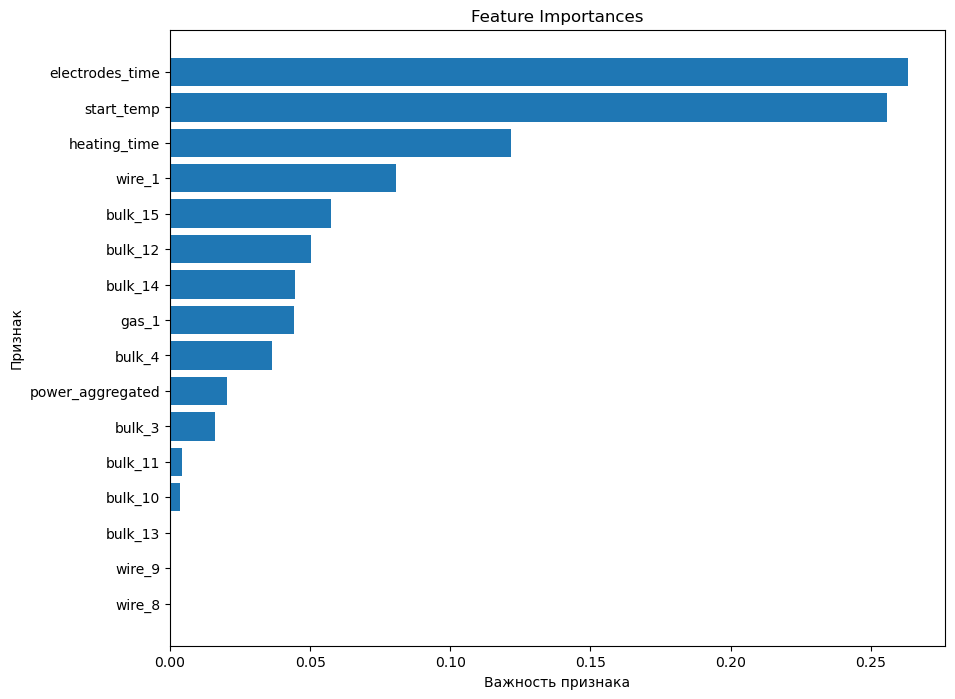

In [73]:
best_model = random_search.best_estimator_.named_steps['models']

feature_importances = best_model.feature_importances_

def plot_feature_importances(feature_importances, feature_names, title='Feature Importances'):
    feature_importances_normalized = feature_importances / feature_importances.sum()
    
    sorted_idx = feature_importances_normalized.argsort()
    
    # Строим график
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importances_normalized[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.title(title)
    plt.show()

plot_feature_importances(feature_importances, X.columns);

**Вывод по разделу**:
- MAE лучшей модели составил `6.28`
- Наиболее `важные признаки`: длительность работы электродов, начальная температура и длительность нагрева

## Заключение <a id="8"></a>

В рамках настоящего исследования анализировались данные металлургического комбината "Стальная Птица" с *целью* построения модели машинного обучения, которая будет предсказывать температуру сплава, чтобы позволить комбинату уменьшить потребление электроэнергии на этапе обработки стали посредством контроля температуры сплава.

**В результате изучения и предобработки были опеределно:**
- Данные содержат информацию об электродах, температуре сплава, добавка (wire и bulk), которые добавляли в сплав на разных этапах цикла
- В данных были пропуски и выбросы - пропуски заменены на 0, выбросы оставлены, так как могут быть важны в рамках задачи
- В данных были аномальые реактивные мощности и температуру ниже справочной - информация о таких ковшах была удалена
- В рамках подготвки данные на основании активной и реактивной мощностей и времени работы электровов были сформированы новые признаки: агрегированная мощность, коэффициент мощности, угол сдвига фаз и статистики по мощности, длительности работы электровдов
- Был добавлен признак длительности нагрева ковша в рамках цикла

**Разработка и обучение моделей:**
- Были применеы и обучены и использованием подбора гиперпараметров `3 модели` машинного обучения (линейная регрессия, лес и кэтбус) - лучшей оказалась `CatBoostRegressper`
- Итоговая `MAE` = `6.28`